In [ ]:
# load splam model
# try to run it


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('drive/MyDrive/Splice')
import SPLAM

#device = 'cuda'
device = 'cpu'

In [ ]:
# load fastas

_chrome = 1
# load chrome
with open(f'drive/MyDrive/Splice/chr{_chrome}_donor_200.fa','r') as f:
    X_donor = f.readlines()
X_donor = X_donor[1::2]
for idx, _line in enumerate(X_donor):
    X_donor[idx] = _line.replace('\n','')

# acceptor
with open(f'drive/MyDrive/Splice/chr{_chrome}_acceptor_200.fa','r') as f:
    X_acceptor = f.readlines()
X_acceptor = X_acceptor[1::2]
for idx, _line in enumerate(X_acceptor):
    X_acceptor[idx] = _line.replace('\n','')

In [ ]:
def encode_simplified(seq: str) -> np.array:
    encoding = np.zeros((len(seq),4))
    # convert to integers to allow lookup
    seq = seq.upper().replace('N','0').replace('A', '1').replace('C', '2').replace('G', '3').replace('T', '4')
    for idx, _s in enumerate(seq):
        encoding[idx] = IN_MAP[int(_s)]

    return encoding

def encode_sequences(seqs: list[str]) -> np.array:
    # encoder all sequences
    # assumed that sequences are padded to uniform length
    encoded_sequences = np.zeros((len(seqs),
                                  len(seqs[0]),
                                  4))
    for idx, _seq in enumerate(seqs):
        encoded_sequences[idx] = encode_simplified(_seq)

    return encoded_sequences


In [ ]:

import torch
from torch.nn import Module, BatchNorm1d, LeakyReLU, Conv1d, ModuleList, Softmax, Sigmoid, Flatten, Dropout2d, Linear
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader
#from splam.splam import SPLAM

import math
import random
import numpy as np
import warnings
import os
import re
#from progress.bar import Bar
import platform

warnings.filterwarnings('ignore')

CARDINALITY_ITEM = 16
SEQ_LEN = 800
JUNC_START = 200
JUNC_END = 600
IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
OUT_MAP = np.asarray([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1],
                      [0, 0, 0]])

def get_donor_acceptor_scores(D_YL, A_YL, D_YP, A_YP):
    return D_YL[:, 200], D_YP[:, 200], A_YL[:, 600], A_YP[:, 600]

def one_hot_encode(Xd, Yd):
    return IN_MAP[Xd.astype('int8')], [OUT_MAP[Yd[t].astype('int8')] for t in range(1)]

def create_datapoints(seq, strand):
    # seq = 'N'*(CL_MAX//2) + seq + 'N'*(CL_MAX//2)
    seq = seq.upper().replace('A', '1').replace('C', '2').replace('G', '3').replace('T', '4')
    pattern = r'[^1234]'
    # Replace non-ACGT characters with 0
    seq = re.sub(pattern, '0', seq)
    jn_start = JUNC_START
    jn_end = JUNC_END

    #######################################
    # predicting pb for every bp
    #######################################
    X0 = np.asarray(list(map(int, list(seq))))
    Y0 = [np.zeros(SEQ_LEN) for t in range(1)]
    if strand == '+':
        for t in range(1):
            Y0[t][jn_start] = 2
            Y0[t][jn_end] = 1
    X, Y = one_hot_encode(X0, Y0)
    return X, Y

def get_cosine_schedule_with_warmup(
      optimizer: Optimizer,
      num_warmup_steps: int,
      num_training_steps: int,
      num_cycles: float = 0.5,
      last_epoch: int = -1,
    ):
    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
          max(1, num_training_steps - num_warmup_steps)
        )
        return max(
          0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )
    return LambdaLR(optimizer, lr_lambda, last_epoch)


def get_accuracy(y_prob, y_true):
    assert y_true.ndim == 1 and y_true.size() == y_prob.size()
    y_prob = y_prob > 0.5
    return (y_true == y_prob).sum().item() / y_true.size(0)

def model_fn(DNAs, labels, model, criterion):
    outs = model(DNAs)
    loss = categorical_crossentropy_2d(labels, outs, criterion)
    return loss, outs

def categorical_crossentropy_2d(y_true, y_pred, criterion):
    SEQ_WEIGHT = 5
    gamma = 2
    return - torch.mean(y_true[:, 0, :] * torch.mul( torch.pow( torch.sub(1, y_pred[:, 0, :]), gamma ), torch.log(y_pred[:, 0, :]+1e-10) )
                        + SEQ_WEIGHT * y_true[:, 1, :] * torch.mul( torch.pow( torch.sub(1, y_pred[:, 1, :]), gamma ), torch.log(y_pred[:, 1, :]+1e-10) )
                        + SEQ_WEIGHT * y_true[:, 2, :] * torch.mul( torch.pow( torch.sub(1, y_pred[:, 2, :]), gamma ), torch.log(y_pred[:, 2, :]+1e-10) ))

def split_seq_name(seq):
    return seq[1:]

class myDataset(Dataset):
    def __init__(self, type, of, shuffle, segment_len=800):
        self.segment_len = segment_len
        self.data = []
        self.indices = []
        pidx = 0
        with open(of, 'r') as f:
            lines = f.read().splitlines()
            seq_name = ''
            seq = ''
            for line in lines:
                if pidx % 2 == 0:
                    seq_name = split_seq_name(line)
                elif pidx % 2 == 1:
                    seq = line
                    if seq[0] == '>':
                        seq_name = line
                        continue
                    X, Y = create_datapoints(seq, '+')
                    X = torch.Tensor(np.array(X))
                    Y = torch.Tensor(np.array(Y)[0])
                    if X.size()[0] != 800:
                        print('seq_name: ', seq_name)
                        print(X.size())
                        print(Y.size())
                    self.data.append([X, Y, seq_name])
                pidx += 1
                if pidx %100000 == 0:
                    print('\t', pidx//2, ' junctions loaded.')

        index_shuf = list(range(len(self.data)))
        if shuffle:
            random.shuffle(index_shuf)
        list_shuf = [self.data[i] for i in index_shuf]
        self.data = list_shuf
        self.indices = index_shuf
        print('\t', pidx//2, ' junctions loaded.')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        feature = self.data[index][0]
        label = self.data[index][1]
        seq_name = self.data[index][2]
        feature = torch.flatten(feature, start_dim=1)
        return feature, label, seq_name

def get_dataloader(batch_size, n_workers, output_file, shuffle, repeat_idx):
    testset = myDataset('test', output_file, shuffle, SEQ_LEN)
    test_loader = DataLoader(
        testset,
        batch_size = batch_size,
        drop_last = False,
        pin_memory = True,
    )
    return test_loader

def load_model(device, model_path):
    try:
        #############################
        # Load empty model first
        #############################
        L = 64
        SEQ_LEN = 800
        JUNC_THRESHOLD = 0.5
        W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                        11, 11, 11, 11, 21, 21, 21, 21,
                        21, 21, 21, 21])
        AR = np.asarray([1, 1, 1, 1, 5, 5, 5, 5,
                         10, 10, 10, 10, 15, 15, 15, 15,
                         20, 20, 20, 20])

        #############################
        # Model Initialization
        #############################
        model = SPLAM(L, W, AR).to(device) # <<<<<<<<
        print("Model initialized successfully")

        # Try different model loading strategies
        model_paths = [model_path]  # Add other paths here if you have more model files to test
        for path in model_paths:
            print(f"Trying to load from {model_path}")
            try:
                # Approach 1: Loading state_dict
                model.load_state_dict(torch.load(model_path, weights_only=False))
                print(">> Model loaded using state_dict")
                break
            except Exception as e:
                print(f"Failed loading state_dict: {e}")

            try:
                # Approach 2: Loading the entire model (if the whole model was saved)
                model = torch.load(model_path, weights_only=False)
                print(">> Model loaded using torch.load")
                break
            except Exception as e:
                print(f"Failed loading with torch.load: {e}")

            try:
                # Approach 3: Loading a TorchScript model (jit)
                model = torch.jit.load(model_path)
                print(">> Model loaded using torch.jit.load")
                break
            except Exception as e:
                print(f"Failed loading with torch.jit.load: {e}")

        try:
            # Ensure the model is on the correct device
            model = model.to(device)
            print("Model moved to device successfully")
        except Exception as e:
            print(f"Failed moving model to device: {e}")
        return model
    except Exception as e:
        print(f"Error during model initialization or loading: {e}")
        return None

def splam_prediction(junction_fasta, out_score_f, model_path, batch_size, device_str):
    BATCH_SIZE = int(batch_size)
    N_WORKERS = None
    if device_str == "NONE":
        device_str = 'cpu'
        if torch.cuda.is_available():
            device_str = 'cuda'
        elif torch.backends.mps.is_available():
            device_str = 'mps'
    device = torch.device(device_str)

    print(f'[Info] Running model in "'+ device_str+'" mode')
    print(f'[Info] Loading model ... (' + model_path + ')', flush = True)
    model = load_model(device, model_path)
    model = model.to(device)

    print(f'[Info] Done loading model', flush = True)
    print(f'[Info] Loading data ...', flush = True)
    test_loader = get_dataloader(BATCH_SIZE, N_WORKERS, junction_fasta, False, str(0))
    print(f'[Info] Done loading data', flush = True)

    criterion = torch.nn.BCELoss()
    fw_junc_scores = open(out_score_f, 'w')

    model.eval()
    junc_counter = 0
    #pbar = Bar('[Info] SPLAM! ', max=len(test_loader))
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            # DNAs:  torch.Size([40, 800, 4])
            # labels:  torch.Size([40, 1, 800, 3])
            DNAs, labels, seqname = data
            DNAs = DNAs.to(torch.float32).to(device)
            labels = labels.to(torch.float32).to(device)

            DNAs = torch.permute(DNAs, (0, 2, 1))
            labels = torch.permute(labels, (0, 2, 1))
            loss, yp = model_fn(DNAs, labels, model, criterion)
            is_expr = (labels.sum(axis=(1,2)) >= 1)
            A_YL = labels[is_expr, 1, :].to('cpu').detach().numpy()
            A_YP = yp[is_expr, 1, :].to('cpu').detach().numpy()
            D_YL = labels[is_expr, 2, :].to('cpu').detach().numpy()
            D_YP = yp[is_expr, 2, :].to('cpu').detach().numpy()

            donor_labels, donor_scores, acceptor_labels, acceptor_scores = get_donor_acceptor_scores(D_YL, A_YL, D_YP, A_YP)
            # added early return
            return donor_labels, donor_scores, acceptor_labels, acceptor_scores

            for idx in range(len(yp)):

                eles = seqname[idx].split(';')
                if len(eles) == 7:
                    chr, start, end, strand, name, aln_num, trans = eles
                    if strand == '+':
                        fw_junc_scores.write(f'{chr}\t{str(start)}\t{str(end)}\t{name}\t{str(aln_num)}\t{strand}\t{str(donor_scores[idx])}\t{str(acceptor_scores[idx])}\t{trans}\n')
                    elif strand == '-':
                        fw_junc_scores.write(f'{chr}\t{str(end)}\t{str(start)}\t{name}\t{str(aln_num)}\t{strand}\t{str(donor_scores[idx])}\t{str(acceptor_scores[idx])}\t{trans}\n')

                else:
                    chr, start, end, strand, name, aln_num = eles
                    if strand == '+':
                        fw_junc_scores.write(f'{chr}\t{str(start)}\t{str(end)}\t{name}\t{str(aln_num)}\t{strand}\t{str(donor_scores[idx])}\t{str(acceptor_scores[idx])}\n')
                    elif strand == '-':
                        fw_junc_scores.write(f'{chr}\t{str(end)}\t{str(start)}\t{name}\t{str(aln_num)}\t{strand}\t{str(donor_scores[idx])}\t{str(acceptor_scores[idx])}\n')

                junc_counter += 1
            # increment the progress bar
     #       pbar.next()

    #pbar.finish()
    fw_junc_scores.close()
    return out_score_f

In [ ]:

from torch.nn import Module, BatchNorm1d, LazyBatchNorm1d, ReLU, LeakyReLU, Conv1d, LazyConv1d, ModuleList, Softmax, Sigmoid, Flatten, Dropout2d, Linear
import numpy as np

CARDINALITY_ITEM = 16

class ResidualUnit(Module):
    def __init__(self, l, w, ar, bot_mul=1):
        super().__init__()
        bot_channels = int(round(l * bot_mul))
        self.batchnorm1 = BatchNorm1d(l)
        self.relu = LeakyReLU(0.1)
        self.batchnorm2 = BatchNorm1d(l)
        self.C = bot_channels//CARDINALITY_ITEM
        self.conv1 = Conv1d(l, l, w, dilation=ar, padding=(w-1)*ar//2, groups=self.C)
        self.conv2 = Conv1d(l, l, w, dilation=ar, padding=(w-1)*ar//2, groups=self.C)

    def forward(self, x, y):
        x1 = self.relu(self.batchnorm1(self.conv1(x)))
        x2 = self.relu(self.batchnorm2(self.conv2(x1)))
        # x1 = self.relu(self.batchnorm1(self.conv1(x)))
        # x2 = self.relu(self.batchnorm1(self.conv1(x1)))

        # print("x : ", x.size())
        # print("x1: ", x1.size())
        # print("x2: ", x2.size())
        return x + x2, y


class Skip(Module):
    def __init__(self, l):
        super().__init__()
        self.conv = Conv1d(l, l, 1)

    def forward(self, x, y):
        return x, self.conv(x) + y


class SPLAM(Module):
    def __init__(self, L=64, W=np.array([11]*8+[21]*4+[41]*4), AR=np.array([1]*4+[4]*4+[10]*4+[25]*4)):
        super().__init__()
        self.CL = 2 * (AR * (W - 1)).sum()  # context length
        self.conv1 = Conv1d(4, L, 1)
        self.skip1 = Skip(L)
        self.residual_blocks = ModuleList()
        for i, (w, r) in enumerate(zip(W, AR)):
            self.residual_blocks.append(ResidualUnit(L, w, r))
            if (i+1) % 4 == 0:
                self.residual_blocks.append(Skip(L))
        if (len(W)+1) % 4 != 0:
            self.residual_blocks.append(Skip(L))
        self.last_cov = Conv1d(L, 3, 1)
        self.softmax = Softmax(dim=1)
        # self.flatten = Flatten()
        # self.drop_out = Dropout2d(0.2)
        # self.fc = Linear(2400, 1)
        # self.softmax = Softmax(dim=1)
        # self.sigmoid = Sigmoid()

    def forward(self, x):
        x, skip = self.skip1(self.conv1(x), 0)
        for m in self.residual_blocks:
            x, skip = m(x, skip)
        #######################################
        # predicting pb for every bp
        #######################################
        return self.softmax(self.last_cov(skip))

        # #######################################
        # # predicting splice / non-splice
        # #######################################
        # output = self.sigmoid(self.fc(self.flatten(self.last_cov(skip))))
        # return output

In [ ]:
# model path
PATH = 'drive/MyDrive/Splice/splam.pt'

z = torch.load(PATH, map_location=device, weights_only=False)


In [ ]:
# load fastas

_chrome = 1

# load chrome
with open(f'drive/MyDrive/Splice/chr{_chrome}_donor.fa','r') as f:
    X_donor = f.readlines()
X_donor = X_donor[1::2]
for idx, _line in enumerate(X_donor):
    X_donor[idx] = _line.replace('\n','')

# acceptor
with open(f'drive/MyDrive/Splice/chr{_chrome}_acceptor.fa','r') as f:
    X_acceptor = f.readlines()
X_acceptor = X_acceptor[1::2]
for idx, _line in enumerate(X_acceptor):
    X_acceptor[idx] = _line.replace('\n','')


donor_encoded = encode_sequences(X_donor)
acceptor_encoded = encode_sequences(X_acceptor)

# concatenate
concatenated_padded = np.zeros((3651,800,4))
for idx, (_a_enc, _d_enc) in enumerate(zip(acceptor_encoded, donor_encoded)):
    concatenated_padded[idx][50:251] = _d_enc
    #concatenated_padded[idx][100:301] = _d_enc
    #concatenated_padded[idx][300+200:701] = _a_enc
    concatenated_padded[idx][200+200:701-100] = _a_enc

concatenated_padded = np.swapaxes(concatenated_padded,axis1=1,axis2=2)
concatenated_padded.shape

(3651, 4, 800)

In [ ]:
# impact of translating sequence
# how much does splam prediction rely on splice sites at position 200 and 600

# -50, +50
sample_idx = 6

offset = np.arange(-50,50)
donor_encoded = encode_sequences(X_donor)
acceptor_encoded = encode_sequences(X_acceptor)
_d_enc = donor_encoded[sample_idx]
_a_enc = acceptor_encoded[sample_idx]

# concatenate
shifted_inputs = np.zeros((len(offset),800,4))
for idx, _offset in enumerate(offset):
    shifted_inputs[idx][100+_offset:301+_offset] = _d_enc
    shifted_inputs[idx][300+200+_offset*2:701+_offset*2] = _a_enc

shifted_inputs = np.swapaxes(shifted_inputs,axis1=1,axis2=2)
shifted_inputs.shape

(100, 4, 800)

In [ ]:
with torch.no_grad():
  shifted_inputs_predictions = z.forward(torch.tensor(shifted_inputs,
                                        dtype=torch.float32).to(device))

shifted_inputs_predictions = shifted_inputs_predictions.to('cpu').detach().numpy()


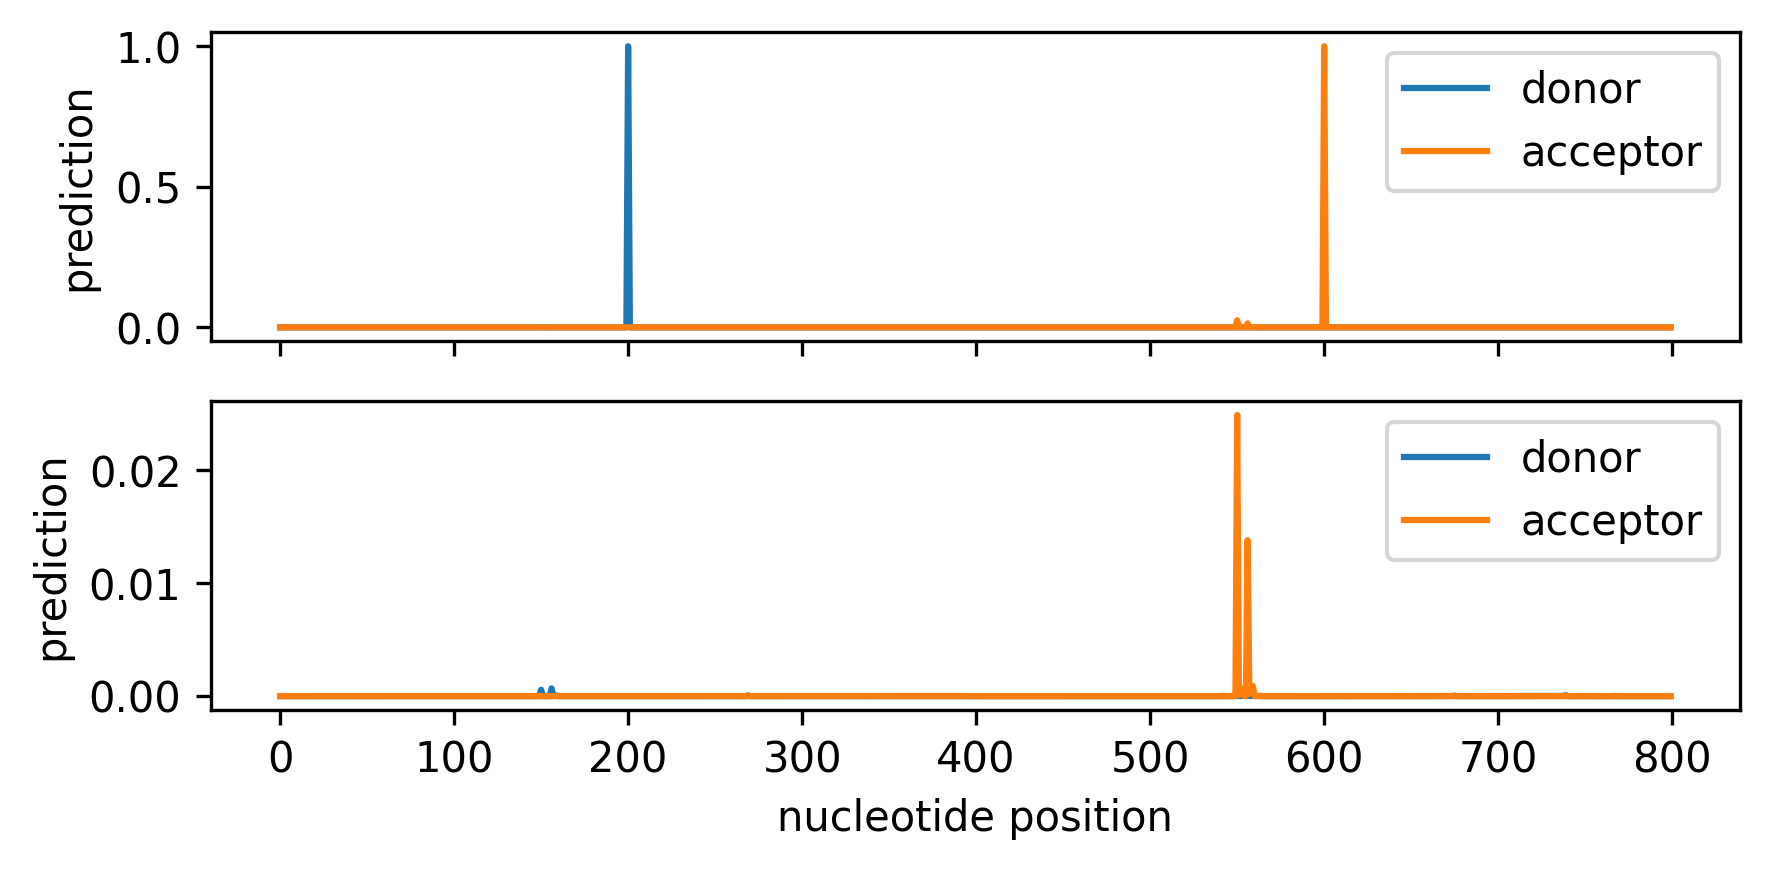

In [ ]:

shifted_inputs_predictions_masked = np.copy(shifted_inputs_predictions)

fig,ax=plt.subplots(2,1,figsize=(6,3),sharex=True,dpi=300)
ax[0].plot(shifted_inputs_predictions_masked[:,2].max(axis=0),label='donor')
ax[0].plot(shifted_inputs_predictions_masked[:,1].max(axis=0),label='acceptor')
ax[0].legend()
ax[0].set_ylabel('prediction');

shifted_inputs_predictions_masked = np.copy(shifted_inputs_predictions)
shifted_inputs_predictions_masked[:,:,200] = 0
shifted_inputs_predictions_masked[:,:,600] = 0

ax[1].plot(shifted_inputs_predictions_masked[:,2].max(axis=0),label='donor')
ax[1].plot(shifted_inputs_predictions_masked[:,1].max(axis=0),label='acceptor')
ax[1].legend()
ax[1].set_xlabel('nucleotide position')
ax[1].set_ylabel('prediction');
plt.tight_layout()
# plt.savefig('drive/MyDrive/shifted_splam_large_text.png')

In [ ]:
# above 2 figures: junctions cannot be shifted forwards or backwards at all.
# this works for splam because this is how it's designed to be used,
# ie, centered on candidate junction pairs

In [ ]:
# so let's change those pairs
# select next 400 junction pairs
# do they "match"

In [ ]:
# roll acceptor
sample_idx = 0

donor_encoded = encode_sequences(X_donor)
acceptor_encoded = encode_sequences(X_acceptor)
_d_enc = donor_encoded[sample_idx]

# concatenate
offset = np.arange(400) # roll the acceptor forward
rolled_inputs = np.zeros((len(offset),800,4))
for idx, _offset in enumerate(offset):
    rolled_inputs[idx][100:301] = _d_enc
    rolled_inputs[idx][300+200:701] = acceptor_encoded[_offset]

rolled_inputs = np.swapaxes(rolled_inputs,axis1=1,axis2=2)
rolled_inputs.shape

(400, 4, 800)

In [ ]:
with torch.no_grad():
  rolled_inputs_predictions = z.forward(torch.tensor(rolled_inputs,
                                                     dtype=torch.float32).to(device))

In [ ]:
# roll acceptor from different chromosome


# acceptor
_chrome = 2
with open(f'drive/MyDrive/Splice/chr{_chrome}_acceptor.fa','r') as f:
    X_acceptor_chr2 = f.readlines()
X_acceptor_chr2 = X_acceptor_chr2[1::2]
for idx, _line in enumerate(X_acceptor_chr2):
    X_acceptor_chr2[idx] = _line.replace('\n','')

acceptor_chr2_encoded = encode_sequences(X_acceptor_chr2)

with open(f'drive/MyDrive/Splice/chr{_chrome}_donor.fa','r') as f:
    X_donor_chr2 = f.readlines()
X_donor_chr2 = X_donor_chr2[1::2]
for idx, _line in enumerate(X_donor_chr2):
    X_donor_chr2[idx] = _line.replace('\n','')

donor_chr2_encoded = encode_sequences(X_donor_chr2)


donor_encoded = encode_sequences(X_donor)
sample_idx = 0
_d_enc = donor_encoded[sample_idx]

# concatenate
offset = np.arange(400) # roll the acceptor forward
rolled_chr2_inputs = np.zeros((len(offset),800,4))
for idx, _offset in enumerate(offset):
    rolled_chr2_inputs[idx][100:301] = _d_enc
    rolled_chr2_inputs[idx][300+200:701] = acceptor_chr2_encoded[_offset]

rolled_chr2_inputs = np.swapaxes(rolled_chr2_inputs,axis1=1,axis2=2)
rolled_chr2_inputs.shape

(400, 4, 800)

In [ ]:
with torch.no_grad():
    rolled_chr2_inputs_predictions = z.forward(torch.tensor(rolled_chr2_inputs,
                                                            dtype=torch.float32).to(device))

rolled_chr2_inputs_predictions = rolled_chr2_inputs_predictions.to('cpu').detach().numpy()

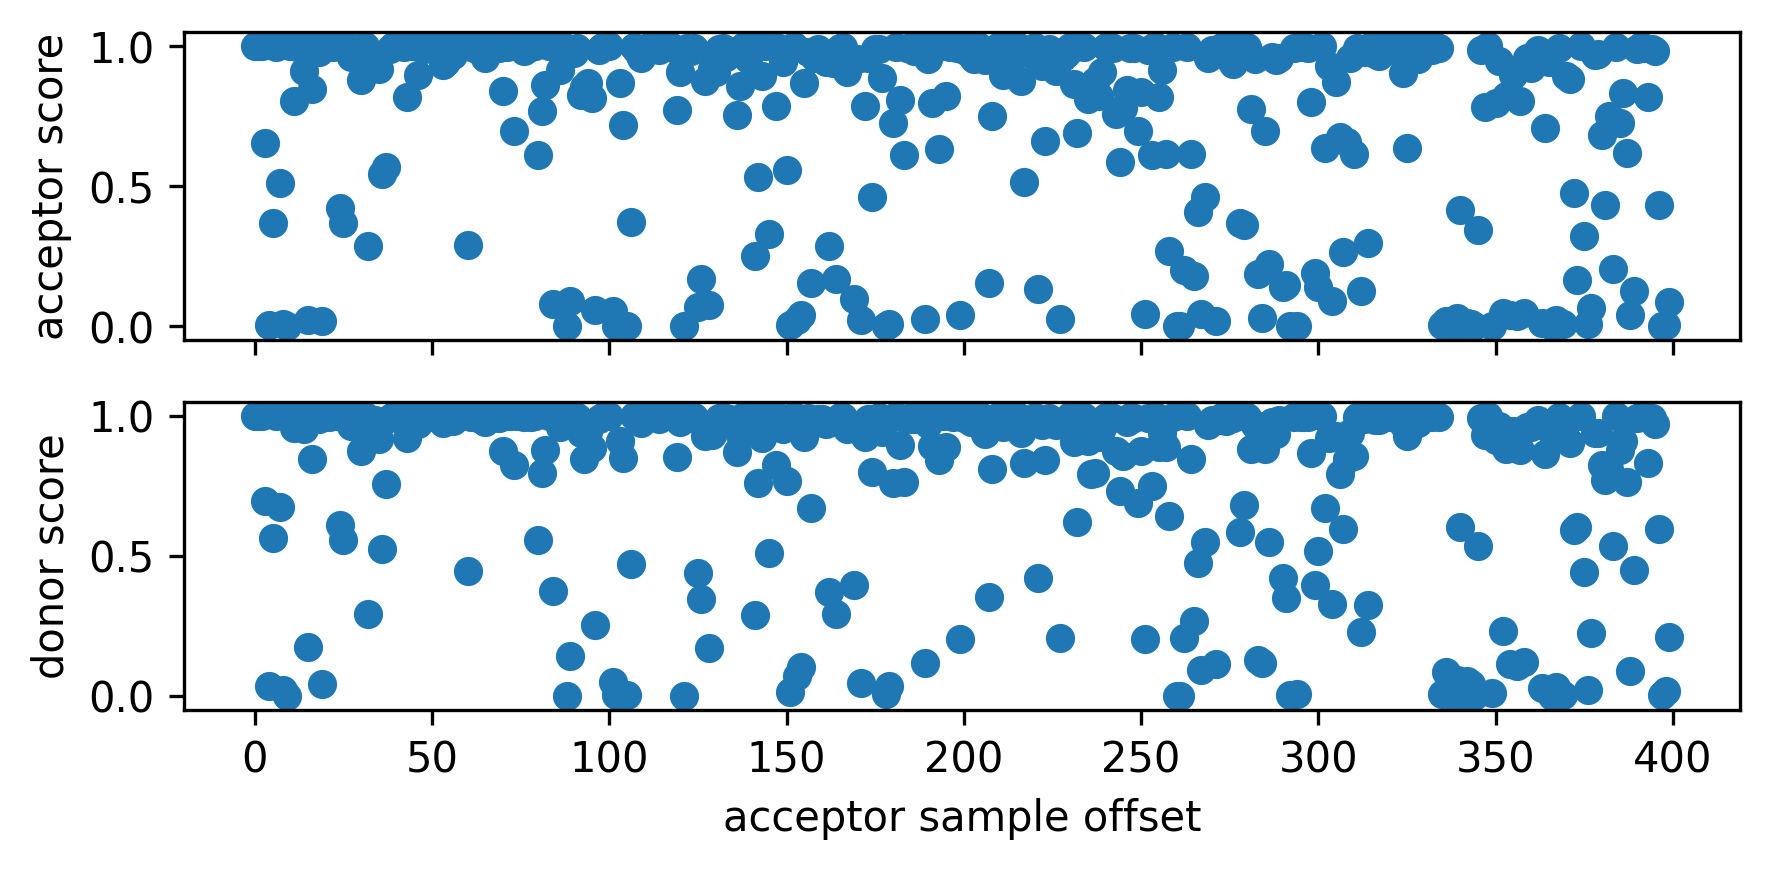

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(6,3),sharex=True,dpi=300)

ax[0].scatter(np.arange(400),
            rolled_chr2_inputs_predictions[:,1,600])
#ax[0].set_xlabel('acceptor sample offset')
ax[0].set_ylabel('acceptor score')

ax[1].scatter(np.arange(400),
            rolled_chr2_inputs_predictions[:,2,200])
ax[1].set_xlabel('acceptor sample offset')
ax[1].set_ylabel('donor score')
plt.tight_layout();

plt.savefig('drive/MyDrive/trans_acceptor_impact_large_text.png')

In [ ]:
# ok, it may be that junction pairs are largely permissive.
# let's loop through donor and acceptor pairs to create a signature for these
# (one donor, 400 junctions, gives a 400-D vector for that donor)
# repeat for 1000 donors




In [ ]:
# doesn't need to be 400D, 256 is fine

In [ ]:
from tqdm import tqdm

signature_dims = 256

# create signatures for donors
donor_signatures = np.zeros((1000,signature_dims))
for _d_idx,_d_enc in tqdm(enumerate(donor_encoded[:1000]),total=1000):
    temp_encoding = np.zeros((signature_dims,800,4))
    for _a_idx in range(signature_dims):
        temp_encoding[_a_idx][100:301] = _d_enc
        temp_encoding[_a_idx][499:700] = acceptor_chr2_encoded[_a_idx]

    temp_encoding = np.swapaxes(temp_encoding,axis1=1,axis2=2)

    with torch.no_grad():
        temp_predictions = z.forward(torch.tensor(temp_encoding,
                                                  dtype=torch.float32).to(device))
    donor_signatures[_d_idx] = temp_predictions[:,2,200].to('cpu').detach().numpy()



# repeat for acceptors
acceptor_signatures = np.zeros((1000,signature_dims))

for _a_idx,_a_enc in tqdm(enumerate(acceptor_chr2_encoded[:1000]),total=1000):
    temp_encoding = np.zeros((signature_dims,800,4))
    for _d_idx in range(signature_dims):
        temp_encoding[_d_idx][100:301] = donor_encoded[_d_idx]
        temp_encoding[_d_idx][499:700] = _a_enc

    temp_encoding = np.swapaxes(temp_encoding,axis1=1,axis2=2)

    with torch.no_grad():
        temp_predictions = z.forward(torch.tensor(temp_encoding,
                                                  dtype=torch.float32).to('cuda'))
    acceptor_signatures[_a_idx] = temp_predictions[:,1,600].to('cpu').detach().numpy()

100%|██████████| 1000/1000 [29:26<00:00,  1.77s/it]


In [ ]:
#np.save('drive/MyDrive/Splice/251125_donor_signatures.npy',donor_signatures)
#np.save('drive/MyDrive/Splice/251125_acceptor_signatures.npy',acceptor_signatures)


In [ ]:
!pip install umap-learn



In [ ]:
!pip install phate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:00


In [ ]:

donor_signatures = np.load('drive/MyDrive/Splice/251125_donor_signatures.npy')
acceptor_signatures = np.load('drive/MyDrive/Splice/251125_acceptor_signatures.npy')

In [ ]:

import umap
from sklearn.preprocessing import StandardScaler
import phate

# umap
# donor
reducer_don = umap.UMAP()
donor_embedded = StandardScaler().fit_transform(donor_signatures)
embedding_don = reducer_don.fit_transform(donor_embedded)

# acceptor
reducer_acc = umap.UMAP()
acceptor_embedded = StandardScaler().fit_transform(acceptor_signatures)
embedding_acc = reducer_acc.fit_transform(acceptor_embedded)

# phate
quick_phate_don = phate.PHATE()
quick_phate_data_don = quick_phate_don.fit_transform(donor_signatures)

quick_phate_acc = phate.PHATE()
quick_phate_data_acc = quick_phate_acc.fit_transform(acceptor_signatures)


Calculating PHATE...
  Running PHATE on 1000 observations and 256 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.19 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.14 seconds.
    Calculating affinities...
    Calculated affinities in 1.32 seconds.
  Calculated graph and diffusion operator in 1.66 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.51 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.14 seconds.
Calculated PHATE in 5.09 seconds.
Calculating PHATE...
  Running PHATE on 1000 observations and 256 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.47 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 sec

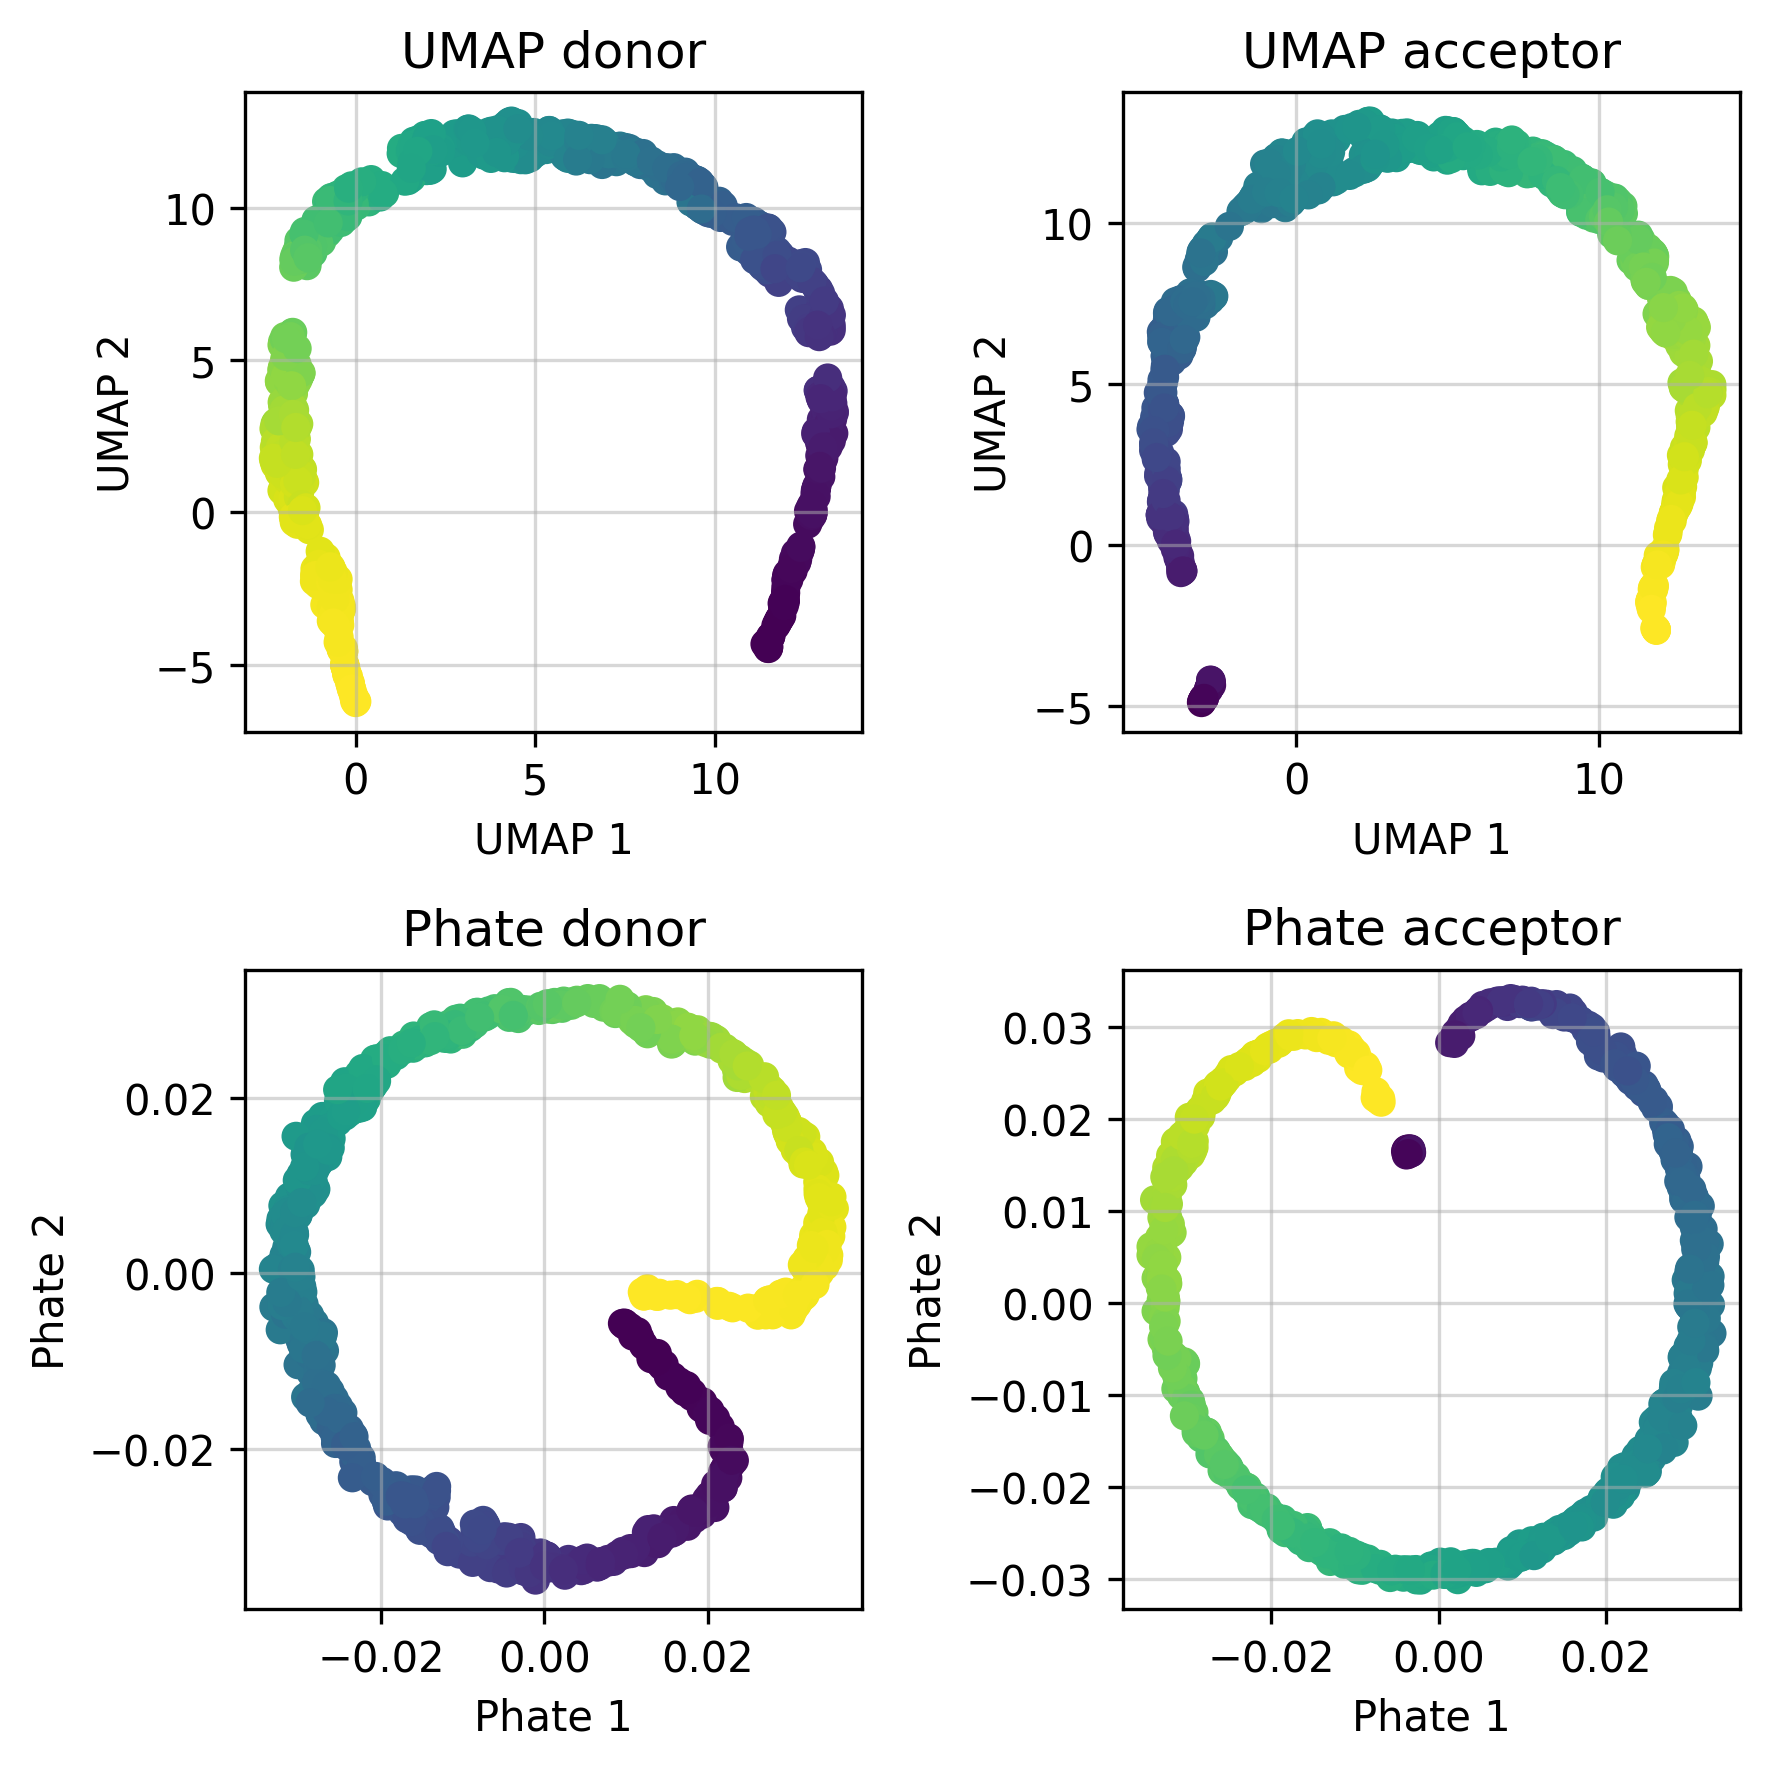

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(6,6),dpi=300)
ax[0][0].scatter(embedding_don[:,0],embedding_don[:,1],c=donor_signatures.mean(axis=1))
ax[0][0].set_title('UMAP donor')
ax[0][0].grid(alpha=0.5)
ax[0][0].set_xlabel('UMAP 1')
ax[0][0].set_ylabel('UMAP 2')

ax[0][1].scatter(embedding_acc[:,0],embedding_acc[:,1],c=acceptor_signatures.mean(axis=1))
ax[0][1].set_title('UMAP acceptor')
ax[0][1].grid(alpha=0.5)
ax[0][1].set_xlabel('UMAP 1')
ax[0][1].set_ylabel('UMAP 2')

ax[1][0].scatter(quick_phate_data_don[:,0],quick_phate_data_don[:,1],c=donor_signatures.mean(axis=1))
ax[1][0].set_title('Phate donor')
ax[1][0].grid(alpha=0.5)
ax[1][0].set_xlabel('Phate 1')
ax[1][0].set_ylabel('Phate 2')

ax[1][1].scatter(quick_phate_data_acc[:,0],quick_phate_data_acc[:,1],c=acceptor_signatures.mean(axis=1))
ax[1][1].set_title('Phate acceptor')
ax[1][1].grid(alpha=0.5)
ax[1][1].set_xlabel('Phate 1')
ax[1][1].set_ylabel('Phate 2');

plt.tight_layout()
# plt.savefig('drive/MyDrive/signature_dim_reduction_large_text.png')

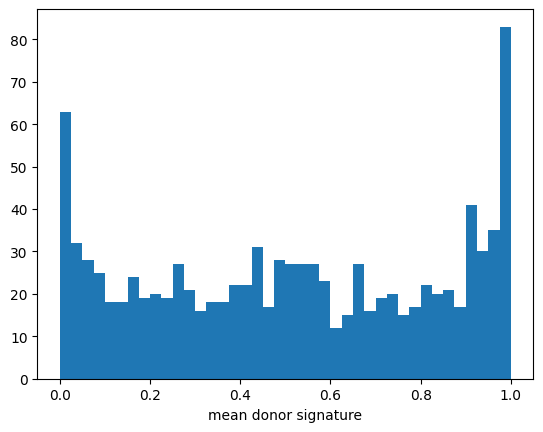

In [ ]:
plt.hist(donor_signatures.mean(axis=1),bins=40);
plt.xlabel('mean donor signature');


array([0.78807551, 0.92455389, 0.9583206 , 0.970504  , 0.97523554,
       0.97890871, 0.98094837, 0.98261963, 0.98382226, 0.98476332])

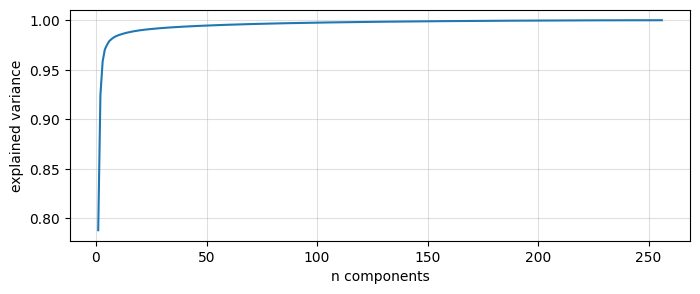

In [ ]:
from sklearn.decomposition import PCA

donor_pca = PCA()
donor_pca.fit(donor_signatures)

plt.figure(figsize=(8,3))
plt.plot(np.arange(1,257), np.cumsum(donor_pca.explained_variance_ratio_));
plt.grid(alpha=0.4)
plt.xlabel('n components')
plt.ylabel('explained variance');

np.cumsum(donor_pca.explained_variance_ratio_)[:10]

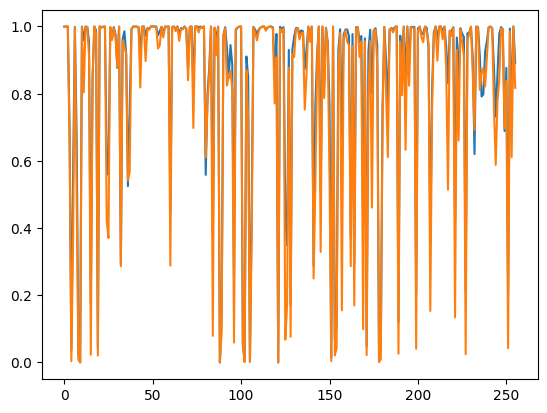

In [ ]:
# does it matter if we use donor scores or acceptor scores? not really. they're pretty much correlated
plt.plot(temp_predictions[:,2,200]);
plt.plot(temp_predictions[:,1,600]);


In [ ]:
# none of the donors and acceptors are proper matches (+/- gene duplications)

mask1 = embedding_acc[:,0] < 0
mask2 = embedding_acc[:,1] < -2.5
mask = mask1 * mask2

outlier_junction = list()
for idx, _m in enumerate(mask):
    if _m:
        outlier_junction.append(X_acceptor_chr2[idx][98:102])
        print(X_acceptor_chr2[idx][98:102])
#print(outlier_junction)

TAGA
CAGA
CAGG
CAGG
AGGC
CACC
TGAT
CAAC
TGAA
TGAG
GAGG
TGGA
AAGG
CAGG
CAGT
TCAA
AGCC
CCCT
CAGG
TAGG
CAGC
CCCT
CAGG


In [ ]:
color_canonical_AG = list()

for _acc_sample in X_acceptor_chr2[:1000]:
    if _acc_sample[100:101] == 'G':
        color_canonical_AG.append(0)
    elif _acc_sample[99:100] == 'A':
        color_canonical_AG.append(0)
    else:
        color_canonical_AG.append(1)
color_canonical_AG = np.array(color_canonical_AG)
color_canonical_AG.sum()

np.int64(73)

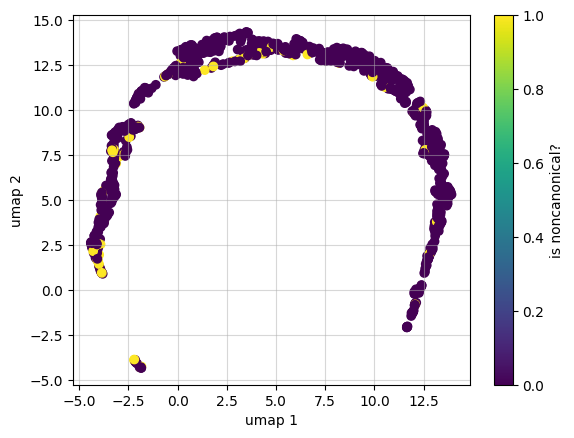

In [ ]:
plt.scatter(embedding_acc[:,0], embedding_acc[:,1],c=color_canonical_AG)
plt.colorbar(label='is noncanonical?');
plt.xlabel('umap 1')
plt.ylabel('umap 2')
plt.grid(alpha=0.5);

In [ ]:
# what are the partner values?
# if we get the matching partner, what's the value that they score
# (how to normalize the above means)

temp_encoding = np.zeros((1000,800,4))

for _idx in range(1000):
    #temp_encoding[_idx][100:301] = donor_encoded[_idx]
    #temp_encoding[_idx][500:701] = acceptor_encoded[_idx]
    temp_encoding[_idx][100:301] = donor_encoded[_idx]
    temp_encoding[_idx][499:700] = acceptor_encoded[_idx]

temp_encoding = np.swapaxes(temp_encoding,axis1=1,axis2=2)
with torch.no_grad():
    temp_predictions = z.forward(torch.tensor(temp_encoding,
                                              dtype=torch.float32).to(device))

donor_scores = temp_predictions[:,2,200].to('cpu').detach().numpy()


In [ ]:
temp_encoding = np.zeros((1000,800,4))

for _idx in range(1000):
    #temp_encoding[_idx][100:301] = donor_chr2_encoded[_idx]
    #temp_encoding[_idx][500:701] = acceptor_chr2_encoded[_idx]
    temp_encoding[_idx][100:301] = donor_chr2_encoded[_idx]
    temp_encoding[_idx][499:700] = acceptor_chr2_encoded[_idx]

temp_encoding = np.swapaxes(temp_encoding,axis1=1,axis2=2)
with torch.no_grad():
    temp_predictions = z.forward(torch.tensor(temp_encoding,
                                              dtype=torch.float32).to(device))

acceptor_chr2_scores = temp_predictions[:,1,600].to('cpu').detach().numpy()


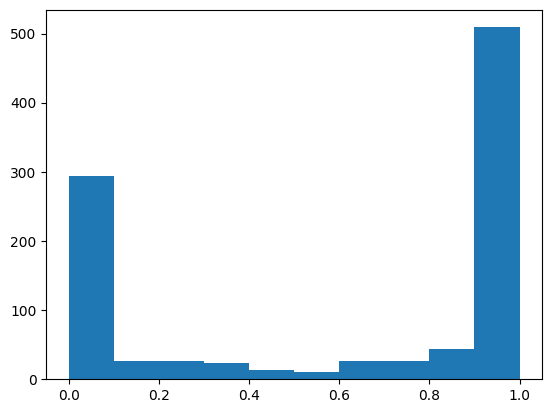

In [ ]:
plt.hist(donor_scores);

In [ ]:
# np.save('drive/MyDrive/donor_matched_scores.npy',donor_scores)
# np.save('drive/MyDrive/acceptor_matched_scores.npy',acceptor_chr2_scores)

donor_scores = np.load('drive/MyDrive/donor_matched_scores.npy')
acceptor_chr2_scores = np.load('drive/MyDrive/acceptor_matched_scores.npy')

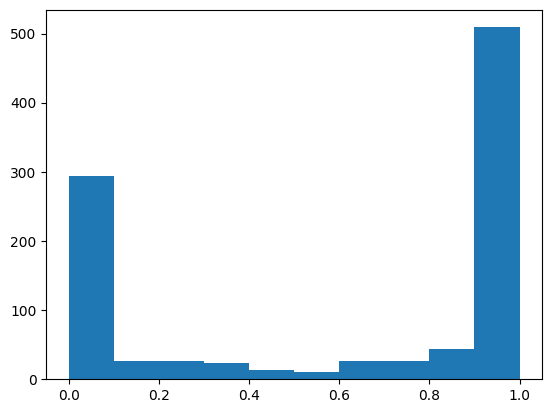

In [ ]:
plt.hist(donor_scores);

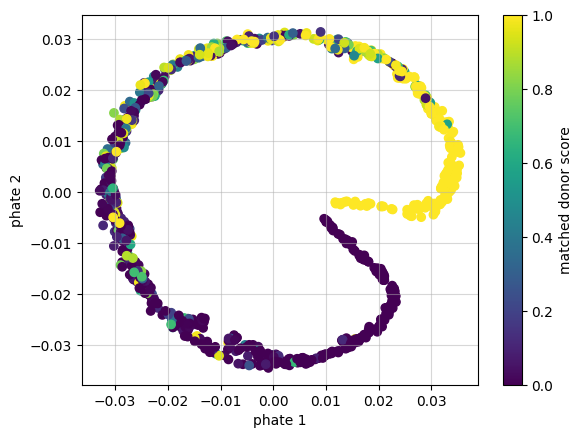

In [ ]:
# standard phate usage

quick_phate = phate.PHATE()
quick_phate_data = quick_phate.fit_transform(donor_signatures)

plt.scatter(*quick_phate_data.T, c=donor_scores)
plt.xlabel('phate 1')
plt.colorbar(label='matched donor score')
plt.grid(alpha=0.5)
plt.ylabel('phate 2');

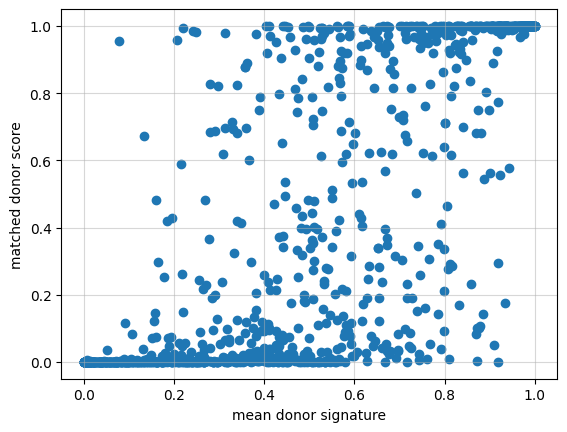

In [ ]:
plt.scatter(donor_signatures.mean(axis=1), donor_scores)
plt.grid(alpha=0.5)
plt.xlabel('mean donor signature')
plt.ylabel('matched donor score');

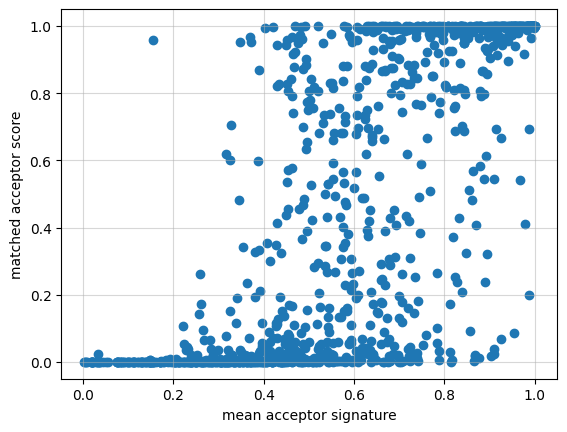

In [ ]:

plt.scatter(acceptor_signatures.mean(axis=1), acceptor_chr2_scores)
plt.grid(alpha=0.5)
plt.xlabel('mean acceptor signature')
plt.ylabel('matched acceptor score');



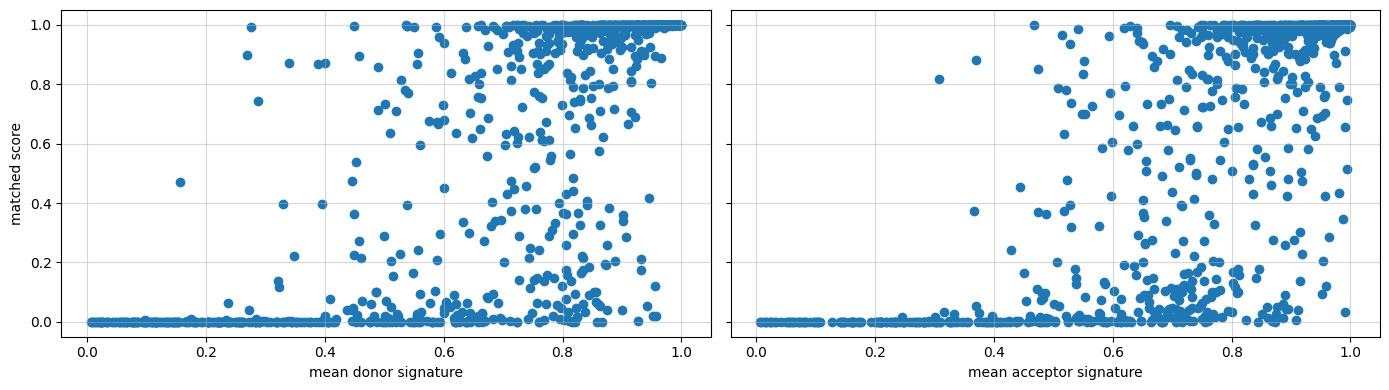

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4),sharey=True)
ax[0].scatter(donor_signatures.mean(axis=1), donor_scores)
ax[0].grid(alpha=0.5)
ax[0].set_xlabel('mean donor signature')
ax[0].set_ylabel('matched score');

ax[1].scatter(acceptor_signatures.mean(axis=1), acceptor_chr2_scores)
ax[1].grid(alpha=0.5)
ax[1].set_xlabel('mean acceptor signature')

plt.tight_layout()
# plt.savefig('drive/MyDrive/junction_scores_v_sig.png')

Calculating PHATE...
  Running PHATE on 1000 observations and 256 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.30 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 0.46 seconds.
  Calculating optimal t...
    Automatically selected t = 23
  Calculated optimal t in 2.04 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.75 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by 2.0% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 3.62 seconds.
Calculated PHATE in 6.90 seconds.


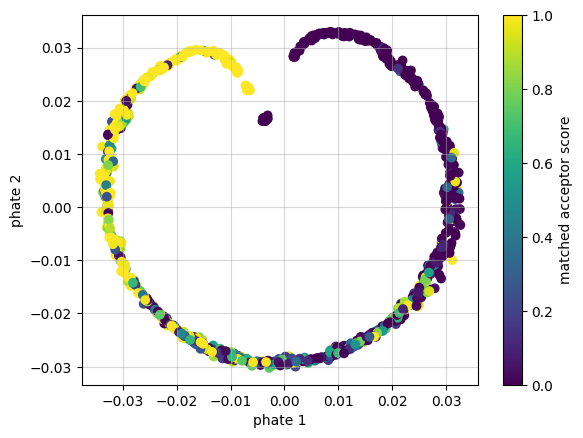

In [ ]:
quick_phate = phate.PHATE()
quick_phate_data = quick_phate.fit_transform(acceptor_signatures)

plt.scatter(*quick_phate_data.T, c=acceptor_chr2_scores)
plt.xlabel('phate 1')
plt.colorbar(label='matched acceptor score')
plt.grid(alpha=0.5)
plt.ylabel('phate 2');